In [1]:
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import SGD

#JIT for the data generation.
from numba import jit

from IPython import display

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data Gen

In [2]:
@jit
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

In [3]:
@jit
def test_data_gen(fakeKernel=False, sigma=0.4):
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas

    return(etasArr, dNBdetas, dNpdy)

In [4]:
def generate_data(size=128):
    baryon = []
    proton = []
    
    for iev in range( size ):
        x, y1, y2 = test_data_gen()
        
        baryon.append(y1)
        proton.append(y2)
                
    return(np.array(baryon, dtype=np.float32), np.array(proton))

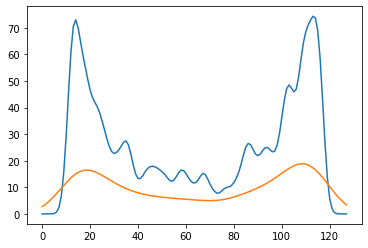

In [5]:
b, p = generate_data(1)

plt.plot(b[0])
plt.plot(p[0])
fig = plt.Figure()

# Generator and Discriminator Models

In [6]:
#Global Constants


BATCH_SIZE = 256

#Encoder
ENCODER_KERNEL_SIZE = 3
ENCODER_RELU_ALPHA = 0.2

#Decoder
DECODER_KERNEL_SIZE = 3
DECODER_RELU_ALPHA = 0.2

#Optimizer Parameters
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-07
LEARNING_RATE = 1e-7

In [258]:
def autoencoder_model(dimShape=(128,1)):
    model = Sequential([
        #Encoder
        layers.Input(shape=dimShape),

        layers.Conv1D(1, 3, strides=4, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv1D(4, 3, strides=4, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv1D(8, 3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        #layers.Dense(8*3),
        
        layers.Conv1DTranspose(8, 3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1DTranspose(4, 3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.UpSampling1D(),
        
        layers.Conv1DTranspose(4, 3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.UpSampling1D(),
        
        layers.Conv1DTranspose(4, 5, strides=4, padding="same", kernel_initializer="ones"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv1DTranspose(2, 7, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.4),
        
        layers.Conv1DTranspose(2, 7, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.5),
        
        layers.Conv1DTranspose(1, 3, padding="same", kernel_initializer="ones"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.4),

        layers.Conv1D(1, 1, padding="same", activation="sigmoid")
    ])

    return(model)

In [259]:
A = autoencoder_model()

A.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 32, 1)             4         
                                                                 
 batch_normalization_258 (Ba  (None, 32, 1)            4         
 tchNormalization)                                               
                                                                 
 leaky_re_lu_258 (LeakyReLU)  (None, 32, 1)            0         
                                                                 
 conv1d_121 (Conv1D)         (None, 8, 4)              16        
                                                                 
 batch_normalization_259 (Ba  (None, 8, 4)             16        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_259 (LeakyReLU)  (None, 8, 4)           

# Training Functions

In [260]:
loss_func = BinaryCrossentropy()

optimizer = Adam(learning_rate = LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)

In [261]:
@tf.function
def train_step(baryon, proton):
    with tf.GradientTape() as tape:
        output = A(baryon)
        loss = loss_func(baryon, output)
    
    grad = tape.gradient(loss, A.trainable_variables)
    optimizer.apply_gradients(zip(grad, A.trainable_variables))
    
    return loss

In [262]:
def train(epochs):
    total_loss = []
    
    for epoch in range(epochs):
        display.clear_output(wait=True)
        print("Epoch: " + str(epoch+1))
        baryon, proton = generate_data(size=BATCH_SIZE)
        loss = train_step(baryon, proton)
        
        # #Negative loss breaker
        # if loss < 0:
        #     print("Loss break")
        #     tf.print(loss)
        #     break
        total_loss.append(loss)
    return np.array(total_loss)

# Test and Train Zone

In [269]:
total_loss = train(50)

Epoch: 50


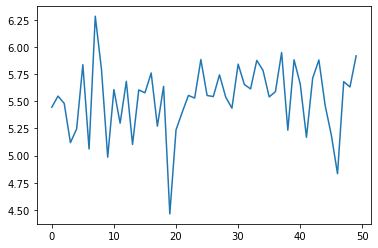

In [270]:
plt.plot(np.arange(0, len(total_loss), 1, int ), total_loss)
fig=plt.Figure()

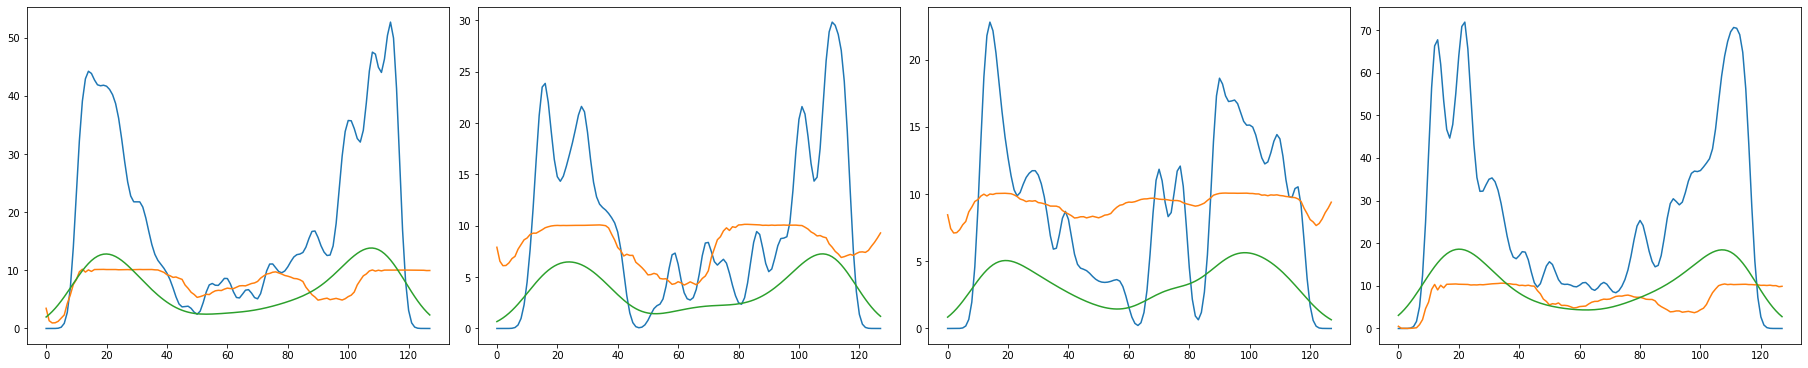

In [273]:
samples = 4
baryon, actual_proton = generate_data(samples)
proton = A(baryon)

fig = plt.figure(constrained_layout=True, figsize=(25,5))
ax_array = fig.subplots(1, samples, squeeze=True)
for i in range(samples):
    ax_array[i].plot(np.arange(0, len(baryon[i]), 1, int ), baryon[i])
    ax_array[i].plot(np.arange(0, len(proton[i]), 1, int ), proton[i]*20)
    ax_array[i].plot(np.arange(0, len(actual_proton[i]), 1, int ), actual_proton[i])